# 001 Computing Exposure Density (250m grid cell level)
* This notebook contains code for computing and visualizing 250m $\times$ 250m grid cell level exposure density.
* Figure 1 in "Exposure Density and Neighborhood Disparities in COVID-19 Infection Risk" published in Proceedings of the National Academy of Sciences of the United States of America (PNAS)

In [1]:
import os
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

import geopandas as gpd
from shapely.geometry import shape
from shapely.geometry import Point 

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Check package/module versions
import types 
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__

import pkg_resources
root_packages = [i.split('.', 1)[0] for i in list(imports())] 
for m in pkg_resources.working_set:
    if m.project_name.lower() in root_packages:
        print (m.project_name, m.version)

pandas 1.1.2
numpy 1.19.2
matplotlib 3.2.0
geopandas 0.8.1


# 1. Load Data 
### 1) 250m $\times$ 250m grid data

In [3]:
grid = pd.read_csv('../../../../../scratch/share/UIL/VenPath/Data/covid_nyc/nyc_land_use/nyc_250mGrid_landUse_active14days_file.csv')
# grid = pd.read_csv('../data/nyc_250mGrid_landUse_active14days_file.csv')
print (len(grid))
grid.head()

31072


,cell_label,x_index,y_index,lon,lat
0,1;43,1,43,-74.251148,40.593881
1,2;90,2,90,-74.248183,40.699518
2,3;99,3,99,-74.245218,40.719746
3,3;39,3,39,-74.245218,40.584890
4,4;109,4,109,-74.242253,40.742222


### 2) 250m grid cell level hourly mobility data associated with land use types
__Land use classification__

     calssification = {
            0:"non-NYC",
            1:"land",  # including sidewalks
            10:"residential",
            11:'residentialBldg',
            20:"mixed",
            21:"mixedBldg",
            30:"commercial",
            31:"commercialBldg",
            40:"industrial",
            41:"industrialBldg",
            50:"openSpace",
            51:"openSpaceBldg",
            60:"parking",
            61:"parkingBldg",
            70:"other",
            71:"otherBldg",
            80:"roads_pedestrianAccess",
            90:"highways",
            100:"roads_other",
        }

In [4]:
data = pd.read_csv('../../../../../scratch/share/UIL/VenPath/Data/covid_nyc/nyc_land_use/nyc_250mGrid_landUse_uniqueDev_hourlyCounts_active14days_file.csv')
# data = pd.read_csv('../data/nyc_250mGrid_landUse_uniqueDev_hourlyCounts_active14days_file.csv')
print (len(data))
data.head()

106063737


,timestamp,cell_label,class,activity
0,2020-03-24 14:00:00,0;113,0.0,6
1,2020-03-22 19:00:00,3;1,11.0,4
2,2020-04-14 19:00:00,6;175,0.0,3
3,2020-04-13 23:00:00,7;143,0.0,1
4,2020-04-21 00:00:00,8;132,0.0,10


### 3) Data investigation and timezone adjustment

* Fill NaT with '2020-03-08 02:00:00'
* Make a 5-hour time shift (left side), if an original timestamp (UTC) is before start of daylight saving ('2020-03-08 02:00:00')
* Mmake an 1-hour time shift to right side (+1hr), if an EST timestamp is equal to or after '2020-03-08 02:00:00'

In [5]:
data['timestamp'] = data['timestamp'].fillna('2020-03-08 02:00:00')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['timestamp_est'] = data['timestamp'] - pd.Timedelta(hours=5)
data['timestamp_est'][data['timestamp_est']>='2020-03-08 02:00:00'] = data['timestamp_est'] + pd.Timedelta(hours=1)
data.head()

,timestamp,cell_label,class,activity,timestamp_est
0,2020-03-24 14:00:00,0;113,0.0,6,2020-03-24 10:00:00
1,2020-03-22 19:00:00,3;1,11.0,4,2020-03-22 15:00:00
2,2020-04-14 19:00:00,6;175,0.0,3,2020-04-14 15:00:00
3,2020-04-13 23:00:00,7;143,0.0,1,2020-04-13 19:00:00
4,2020-04-21 00:00:00,8;132,0.0,10,2020-04-20 20:00:00


# 2. Grouping detailed land use types
* Out of the city boundary (this will be dropped)
* Residential
* Non residential
* Outdoor 
* Highway or vehicle only road

In [6]:
data['label'] = 'NN' # out of the city boundary
data['label'][data['class'].isin([10, 11, 20, 21])] = 'R' # residential
data['label'][data['class'].isin([30, 31, 40, 41, 60, 61, 70, 71])] = 'NR' # non residential
data['label'][data['class'].isin([1, 50, 51, 80, 100])] = 'O' # outdoor
data['label'][data['class'].isin([90])] = 'V' # highway

# Drop data outside of the city boundary
df = data[data['label']!='NN']

# Add a column with data information
df['date'] = df['timestamp_est'].dt.date
df.head()

,timestamp,cell_label,class,activity,timestamp_est,label,date
1,2020-03-22 19:00:00,3;1,11.0,4,2020-03-22 15:00:00,R,2020-03-22
15,2020-03-25 09:00:00,48;51,100.0,3,2020-03-25 05:00:00,O,2020-03-25
16,2020-03-16 11:00:00,56;62,30.0,3,2020-03-16 07:00:00,NR,2020-03-16
19,2020-04-25 18:00:00,73;61,50.0,14,2020-04-25 14:00:00,O,2020-04-25
20,2020-03-28 02:00:00,77;57,100.0,6,2020-03-27 22:00:00,O,2020-03-27


# 3. 250m grid level daily neighborhood activity

* Total activity regardless of land use types

In [7]:
df_group_sum_cell = df.groupby(['date', 'cell_label']).sum().reset_index().pivot(index='date', columns='cell_label',
                                                                                      values='activity')
df_group_sum_cell = df_group_sum_cell.fillna(0)
df_group_sum_cell.head()

cell_label,0;1,0;2,0;3,0;4,0;5,0;6,0;7,100;100,100;101,100;102,...,9;25,9;26,9;27,9;3,9;4,9;5,9;6,9;7,9;8,9;9
date,,,,,,,,,,,,,,,,,,,,,
2020-01-31,0.0,0.0,0.0,8.0,2.0,0.0,0.0,17.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
2020-02-01,0.0,0.0,0.0,14.0,0.0,0.0,5.0,108.0,32.0,34.0,...,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
2020-02-02,0.0,0.0,0.0,5.0,2.0,0.0,1.0,102.0,15.0,23.0,...,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0
2020-02-03,0.0,0.0,1.0,9.0,2.0,0.0,0.0,75.0,26.0,39.0,...,0.0,0.0,0.0,0.0,0.0,12.0,0.0,0.0,0.0,0.0
2020-02-04,0.0,0.0,0.0,5.0,3.0,1.0,0.0,78.0,26.0,61.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


* Activities in a given land use type (residential, non residential, outdoor, and highway)

In [9]:
# Filtering neighborhood with few activity
valid_cell = []
for c in df_group_sum_cell.columns.tolist():
    if df_group_sum_cell[c].mean()>=5:
        valid_cell.append(c)
    else:
        pass

# print (len(df_group_sum_cell.columns.tolist()))
# print (len(valid_cell))

df_group_sum_cell_label = df[df['cell_label'].isin(valid_cell)].groupby(['date', 'cell_label', 'label']).mean().reset_index()
df_group_sum_cell_label.head()

,date,cell_label,label,class,activity
0,2020-01-31,0;4,O,100.000000,1.000000
1,2020-01-31,0;4,R,10.500000,1.000000
2,2020-01-31,0;5,R,10.000000,1.000000
3,2020-01-31,100;100,NR,31.000000,1.000000
4,2020-01-31,100;100,O,71.714286,1.428571


In [10]:
# Activity volmue in a given land use type
df_O = pd.DataFrame(index=df_group_sum_cell.index, columns=valid_cell)
df_O.update(df_group_sum_cell_label[df_group_sum_cell_label['label']=='O'].pivot(index='date', columns='cell_label', values='activity'))

df_R = pd.DataFrame(index=df_group_sum_cell.index, columns=valid_cell)
df_R.update(df_group_sum_cell_label[df_group_sum_cell_label['label']=='R'].pivot(index='date', columns='cell_label', values='activity'))

df_NR = pd.DataFrame(index=df_group_sum_cell.index, columns=valid_cell)
df_NR.update(df_group_sum_cell_label[df_group_sum_cell_label['label']=='NR'].pivot(index='date', columns='cell_label', values='activity'))

df_V = pd.DataFrame(index=df_group_sum_cell.index, columns=valid_cell)
df_V.update(df_group_sum_cell_label[df_group_sum_cell_label['label']=='V'].pivot(index='date', columns='cell_label', values='activity'))

In [11]:
df_O = df_O.fillna(0)
df_R = df_R.fillna(0)
df_NR = df_NR.fillna(0)
df_V = df_V.fillna(0)

* Pre-covid: 2020-02-16 ~ 2020-02-29
* Post-covid: 2020-03-28 ~ 2020-04-11

In [12]:
# Calculating activity proportions in a given land use type
df_O_pct = df_O/(df_O+df_R+df_NR)#+df_V)
df_R_pct = df_R/(df_O+df_R+df_NR)#+df_V)
df_NR_pct = df_NR/(df_O+df_R+df_NR)#+df_V)
# df_V_pct = df_V/(df_O+df_R+df_NR+df_V)

df_O_pct = df_O_pct.fillna(0)
df_R_pct = df_R_pct.fillna(0)
df_NR_pct = df_NR_pct.fillna(0)
# df_V_pct = df_V_pct.fillna(0)

In [13]:
# Activity volume in a given land use type before the stay-at-home order (pre-covid)
df_O_pre = df_O.iloc[15:29,:].T
df_R_pre = df_R.iloc[15:29,:].T
df_NR_pre = df_NR.iloc[15:29,:].T
# df_V_pre = df_V.iloc[15:29,:].T

# Activity proportion in a given land use type before the stay-at-home order (pre-covid)
df_O_pct_pre = df_O_pct.iloc[15:29,:].T
df_R_pct_pre = df_R_pct.iloc[15:29,:].T
df_NR_pct_pre = df_NR_pct.iloc[15:29,:].T
# df_V_pct_pre = df_V_pct.iloc[15:29,:].T

In [14]:
# Activity volume in a given land use type after the stay-at-home order (post-covid)
df_O_post = df_O.iloc[50:57,:].T
df_R_post = df_R.iloc[50:57,:].T
df_NR_post = df_NR.iloc[50:57,:].T
# df_V_post = df_V.iloc[50:57,:].T

# Activity proportion in a given land use type after the stay-at-home order (post-covid)
df_O_pct_post = df_O_pct.iloc[50:57,:].T
df_R_pct_post = df_R_pct.iloc[50:57,:].T
df_NR_pct_post = df_NR_pct.iloc[50:57,:].T
# df_V_pct_post = df_V_pct.iloc[50:57,:].T

# 4. Computing average exposure density change
### 1) Grid cell level average exposure density in a given land use type

In [15]:
df_O_pre['avg_O_pre'] = df_O_pre.mean(axis=1)
df_R_pre['avg_R_pre'] = df_R_pre.mean(axis=1)
df_NR_pre['avg_NR_pre'] = df_NR_pre.mean(axis=1)
# df_V_pre['avg_V_pre'] = df_V_pre.mean(axis=1)

df_O_post['avg_O_post'] = df_O_post.mean(axis=1)
df_R_post['avg_R_post'] = df_R_post.mean(axis=1)
df_NR_post['avg_NR_post'] = df_NR_post.mean(axis=1)
# df_V_post['avg_V_post'] = df_V_post.mean(axis=1)

In [16]:
df_O_pct_pre['avg_O_pct_pre'] = df_O_pct_pre.mean(axis=1)
df_R_pct_pre['avg_R_pct_pre'] = df_R_pct_pre.mean(axis=1)
df_NR_pct_pre['avg_NR_pct_pre'] = df_NR_pct_pre.mean(axis=1)
# df_V_pct_pre['avg_V_pct_pre'] = df_V_pct_pre.mean(axis=1)

df_O_pct_post['avg_O_pct_post'] = df_O_pct_post.mean(axis=1)
df_R_pct_post['avg_R_pct_post'] = df_R_pct_post.mean(axis=1)
df_NR_pct_post['avg_NR_pct_post'] = df_NR_pct_post.mean(axis=1)
# df_V_pct_post['avg_V_pct_post'] = df_V_pct_post.mean(axis=1)

In [17]:
df_O_pre = df_O_pre.reset_index()
df_R_pre = df_R_pre.reset_index()
df_NR_pre = df_NR_pre.reset_index()
# df_V_pre = df_V_pre.reset_index()

df_O_pct_pre = df_O_pct_pre.reset_index()
df_R_pct_pre = df_R_pct_pre.reset_index()
df_NR_pct_pre = df_NR_pct_pre.reset_index()
# df_V_pct_pre = df_V_pct_pre.reset_index()

In [18]:
df_O_post = df_O_post.reset_index()
df_R_post = df_R_post.reset_index()
df_NR_post = df_NR_post.reset_index()
# df_V_post = df_V_post.reset_index()

df_O_pct_post = df_O_pct_post.reset_index()
df_R_pct_post = df_R_pct_post.reset_index()
df_NR_pct_post = df_NR_pct_post.reset_index()
# df_V_pct_post = df_V_pct_post.reset_index()

In [19]:
# Merge data to create one integrated summary table
df_cell_comp = pd.merge(df_O_pre[['index', 'avg_O_pre']],df_R_pre[['index', 'avg_R_pre']], how='outer', on='index')
df_cell_comp = pd.merge(df_cell_comp, df_NR_pre[['index', 'avg_NR_pre']], how='outer', on='index')
# df_cell_comp = pd.merge(df_cell_comp, df_V_pre[['index', 'avg_V_pre']], how='outer', on='index')
df_cell_comp = pd.merge(df_cell_comp, df_O_post[['index', 'avg_O_post']], how='outer', on='index')
df_cell_comp = pd.merge(df_cell_comp, df_R_post[['index', 'avg_R_post']], how='outer', on='index')
df_cell_comp = pd.merge(df_cell_comp, df_NR_post[['index', 'avg_NR_post']], how='outer', on='index')
# df_cell_comp = pd.merge(df_cell_comp, df_V_post[['index', 'avg_V_post']], how='outer', on='index')
df_cell_comp = pd.merge(df_cell_comp, df_O_pct_pre[['index', 'avg_O_pct_pre']], how='outer', on='index')
df_cell_comp = pd.merge(df_cell_comp, df_R_pct_pre[['index', 'avg_R_pct_pre']], how='outer', on='index')
df_cell_comp = pd.merge(df_cell_comp, df_NR_pct_pre[['index', 'avg_NR_pct_pre']], how='outer', on='index')
# df_cell_comp = pd.merge(df_cell_comp, df_V_pct_pre[['index', 'avg_V_pct_pre']], how='outer', on='index')
df_cell_comp = pd.merge(df_cell_comp, df_O_pct_post[['index', 'avg_O_pct_post']], how='outer', on='index')
df_cell_comp = pd.merge(df_cell_comp, df_R_pct_post[['index', 'avg_R_pct_post']], how='outer', on='index')
df_cell_comp = pd.merge(df_cell_comp, df_NR_pct_post[['index', 'avg_NR_pct_post']], how='outer', on='index')
# df_cell_comp = pd.merge(df_cell_comp, df_V_pct_post[['index', 'avg_V_pct_post']], how='outer', on='index')

### 2) Computing neighborhood activity change in a given land use type

In [20]:
df_cell_comp['delta_O'] = df_cell_comp['avg_O_post'] - df_cell_comp['avg_O_pre']
df_cell_comp['delta_R'] = df_cell_comp['avg_R_post'] - df_cell_comp['avg_R_pre']
df_cell_comp['delta_NR'] = df_cell_comp['avg_NR_post'] - df_cell_comp['avg_NR_pre']
# df_cell_comp['delta_V'] = df_cell_comp['avg_V_post'] - df_cell_comp['avg_V_pre']

df_cell_comp['delta_O_norm'] = df_cell_comp['delta_O']/df_cell_comp['avg_O_pre']
df_cell_comp['delta_R_norm'] = df_cell_comp['delta_R']/df_cell_comp['avg_R_pre']
df_cell_comp['delta_NR_norm'] = df_cell_comp['delta_NR']/df_cell_comp['avg_NR_pre']
# df_cell_comp['delta_V_norm'] = df_cell_comp['delta_V']/df_cell_comp['avg_V_pre']

df_cell_comp['delta_O_pct'] = df_cell_comp['avg_O_pct_post'] - df_cell_comp['avg_O_pct_pre']
df_cell_comp['delta_R_pct'] = df_cell_comp['avg_R_pct_post'] - df_cell_comp['avg_R_pct_pre']
df_cell_comp['delta_NR_pct'] = df_cell_comp['avg_NR_pct_post'] - df_cell_comp['avg_NR_pct_pre']
# df_cell_comp['delta_V_pct'] = df_cell_comp['avg_V_pct_post'] - df_cell_comp['avg_V_pct_pre']

### 3) Computing neighborhood exposure density change 
* Non residential
* Outdoor

In [21]:
# Compute exposure density (activities in non-residential and outdoor land uses)
# Compute exposure density change before and after the stay-at-home order
df_cell_comp['avg_NRO_pre'] = df_cell_comp['avg_O_pre'] + df_cell_comp['avg_NR_pre']
df_cell_comp['avg_NRO_post'] = df_cell_comp['avg_O_post'] + df_cell_comp['avg_NR_post']
df_cell_comp['delta_NRO'] = df_cell_comp['avg_NRO_post'] - df_cell_comp['avg_NRO_pre']
df_cell_comp['delta_NRO_pct'] = df_cell_comp['delta_NRO']/df_cell_comp['avg_NRO_pre']
df_cell_comp.head()

date,index,avg_O_pre,avg_R_pre,avg_NR_pre,avg_O_post,avg_R_post,avg_NR_post,avg_O_pct_pre,avg_R_pct_pre,avg_NR_pct_pre,...,delta_O_norm,delta_R_norm,delta_NR_norm,delta_O_pct,delta_R_pct,delta_NR_pct,avg_NRO_pre,avg_NRO_post,delta_NRO,delta_NRO_pct
0,0;4,1.040363,1.118295,0.000000,1.200866,1.101082,0.000000,0.482742,0.517258,0.000000,...,0.154276,-0.015392,NaN,0.038315,-0.038315,0.000000,1.040363,1.200866,0.160503,0.154276
1,0;5,1.072109,1.433431,0.000000,1.071429,1.706719,0.000000,0.426734,0.573266,0.000000,...,-0.000635,0.190653,NaN,-0.040480,0.040480,0.000000,1.072109,1.071429,-0.000680,-0.000635
2,100;100,4.060062,3.416761,1.361086,1.908508,1.965956,1.171642,0.455887,0.386891,0.157221,...,-0.529931,-0.424614,-0.139186,-0.078402,0.001054,0.077348,5.421148,3.080150,-2.340998,-0.431827
3,100;101,1.859757,1.274769,2.292466,1.590869,1.325598,1.840143,0.342154,0.236002,0.421844,...,-0.144582,0.039873,-0.197309,-0.007849,0.043003,-0.035154,4.152223,3.431012,-0.721211,-0.173693
4,100;102,1.917192,0.285714,1.935648,1.970163,0.000000,1.386224,0.468462,0.060159,0.471379,...,0.027629,-1.000000,-0.283845,0.116819,-0.060159,-0.056660,3.852840,3.356387,-0.496453,-0.128854


In [22]:
df_cell_comp = df_cell_comp.rename(columns={'index':'cell_label'})

# Merge with the grid information
df_cell_comp = pd.merge(df_cell_comp, grid[['cell_label', 'lon', 'lat']], how='left', on='cell_label')
df_cell_comp.head()

,cell_label,avg_O_pre,avg_R_pre,avg_NR_pre,avg_O_post,avg_R_post,avg_NR_post,avg_O_pct_pre,avg_R_pct_pre,avg_NR_pct_pre,...,delta_NR_norm,delta_O_pct,delta_R_pct,delta_NR_pct,avg_NRO_pre,avg_NRO_post,delta_NRO,delta_NRO_pct,lon,lat
0,0;4,1.040363,1.118295,0.000000,1.200866,1.101082,0.000000,0.482742,0.517258,0.000000,...,NaN,0.038315,-0.038315,0.000000,1.040363,1.200866,0.160503,0.154276,-74.254113,40.506224
1,0;5,1.072109,1.433431,0.000000,1.071429,1.706719,0.000000,0.426734,0.573266,0.000000,...,NaN,-0.040480,0.040480,0.000000,1.072109,1.071429,-0.000680,-0.000635,-74.254113,40.508472
2,100;100,4.060062,3.416761,1.361086,1.908508,1.965956,1.171642,0.455887,0.386891,0.157221,...,-0.139186,-0.078402,0.001054,0.077348,5.421148,3.080150,-2.340998,-0.431827,-73.957622,40.721994
3,100;101,1.859757,1.274769,2.292466,1.590869,1.325598,1.840143,0.342154,0.236002,0.421844,...,-0.197309,-0.007849,0.043003,-0.035154,4.152223,3.431012,-0.721211,-0.173693,-73.957622,40.724241
4,100;102,1.917192,0.285714,1.935648,1.970163,0.000000,1.386224,0.468462,0.060159,0.471379,...,-0.283845,0.116819,-0.060159,-0.056660,3.852840,3.356387,-0.496453,-0.128854,-73.957622,40.726489


# 5. Mapping 250m grid neighborhood exposure density change

In [23]:
# Create geometry from longitude and latitude information

geometry = [Point(xy) for xy in zip(df_cell_comp['lon'],df_cell_comp['lat'])]

# Setting CRS (EPSG:2263) and convert to geopandas dataframe
gdf = gpd.GeoDataFrame(df_cell_comp, crs="EPSG:4326", geometry=geometry)
gdf = gdf.to_crs('EPSG:2263')

gdf.head()

,cell_label,avg_O_pre,avg_R_pre,avg_NR_pre,avg_O_post,avg_R_post,avg_NR_post,avg_O_pct_pre,avg_R_pct_pre,avg_NR_pct_pre,...,delta_O_pct,delta_R_pct,delta_NR_pct,avg_NRO_pre,avg_NRO_post,delta_NRO,delta_NRO_pct,lon,lat,geometry
0,0;4,1.040363,1.118295,0.000000,1.200866,1.101082,0.000000,0.482742,0.517258,0.000000,...,0.038315,-0.038315,0.000000,1.040363,1.200866,0.160503,0.154276,-74.254113,40.506224,POINT (913584.635 123810.316)
1,0;5,1.072109,1.433431,0.000000,1.071429,1.706719,0.000000,0.426734,0.573266,0.000000,...,-0.040480,0.040480,0.000000,1.072109,1.071429,-0.000680,-0.000635,-74.254113,40.508472,POINT (913587.010 124629.163)
2,100;100,4.060062,3.416761,1.361086,1.908508,1.965956,1.171642,0.455887,0.386891,0.157221,...,-0.078402,0.001054,0.077348,5.421148,3.080150,-2.340998,-0.431827,-73.957622,40.721994,POINT (995996.670 202321.155)
3,100;101,1.859757,1.274769,2.292466,1.590869,1.325598,1.840143,0.342154,0.236002,0.421844,...,-0.007849,0.043003,-0.035154,4.152223,3.431012,-0.721211,-0.173693,-73.957622,40.724241,POINT (995996.274 203140.025)
4,100;102,1.917192,0.285714,1.935648,1.970163,0.000000,1.386224,0.468462,0.060159,0.471379,...,0.116819,-0.060159,-0.056660,3.852840,3.356387,-0.496453,-0.128854,-73.957622,40.726489,POINT (995995.878 203958.894)


In [24]:
# Load borough shapefile
boro = gpd.read_file('../data/shape/boro.shp') # initial crs = epsg:4326
boro = boro.to_crs('EPSG:2263') # convert a crs system to epsg:2263
boro = boro.set_index('boro_name')

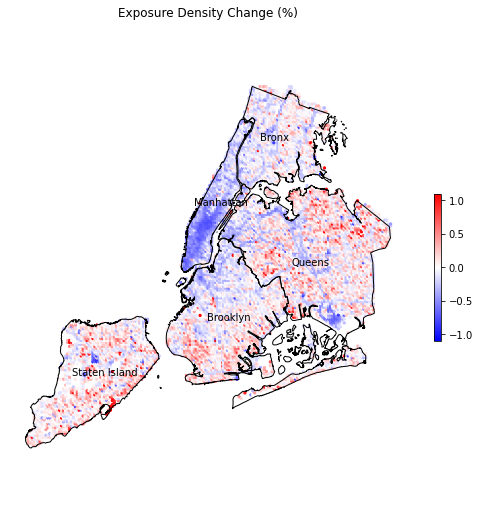

In [25]:
# Mapping neighborhood exposure density change before and after COVID-19 at 250m grid resolution
fig, ax = plt.subplots(figsize=(9,9))
gdf.plot(column='delta_NRO_pct', cmap='bwr', ax = ax, vmin=-1.1, vmax=1.1,s=5, 
            legend=True, legend_kwds={'shrink':0.3})

# Add borough boundary and corresponding names
boro.boundary.plot(ax=ax, color='k', linewidth=1)
for i, geo in boro.centroid.iteritems():
    ax.annotate(s=i, xy=[geo.x-9000, geo.y], color="k")
    ax.figure

plt.title('Exposure Density Change (%)')
plt.axis('equal')
plt.axis(False)
# plt.savefig('../figures/exposure_density_change_250m_grid.pdf', dpi=600) 
plt.show()